In [ ]:
!pip install boto3

In [ ]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = ['val2017.zip', 'annotations_trainval2017.zip', 'train2017.zip']

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

In [ ]:
from pycocotools.coco import COCO
import json
import numpy as np
import pandas as pd
import skimage.io as io
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
def generate_heatmap_3D(image):
  kp_img = image.copy()
  tensor3d = torch.zeros(17, 256, 192)
  for idx, k in enumerate(range(len(keypoint_text))):
    x = 'x'+ str(idx)
    y = 'y'+ str(idx)
    v = 'v'+ str(idx)
    text = keypoint_text[idx]
    visible = int(keypoint_df[v])

    # print(idx,int(keypoint_df[x]),int(keypoint_df[y]),int(keypoint_df[v]),text) 
    # adjusted keypoint location in resized image
    adjusted_pt = get_scaled_point(int(keypoint_df[x]),int(keypoint_df[y]))
    pt_x = adjusted_pt[0]
    pt_y = adjusted_pt[1]
    # print(idx,pt_x,pt_y)
    if(visible == 0):
      tensor3d[idx,pt_y,pt_x] = 0
    else:
      tensor3d[idx,pt_y,pt_x] = 1

    # tensor3d[idx] = torch.div(tensor3d[idx], 255)

    # Putting text on keypoints
    # pt = (pt_x+5,pt_y+1)
    # cv2.putText(kp_img,text, pt, font, scale, color_white, thickness, cv2.LINE_AA)
    # fig, ax = plt.subplots(figsize=(10, 8))
    # plt.imshow(tensor3d[idx].numpy(), cmap='gray')
  return tensor3d



In [ ]:
def get_scaled_point(x,y):
  xy = np.asarray([bbox[0],bbox[1]])
  kp = np.asarray([x,y])
  diff = np.subtract(kp,xy)
  return np.round(diff*scale_factor).astype(int)

In [ ]:
# variable initialization
path = '/content/'
kp_json = path + 'annotations/person_keypoints_val2017.json'
kp_cols= []
img_id = 65736
scale = 0.28
font = cv2.FONT_HERSHEY_SIMPLEX
thickness = 1
color_red = (255, 0, 0)
color_white = (255, 255, 255)
color_blue = (0, 0, 255)
alpha = 0.4
resize_h = 256
resize_w = 192

In [ ]:
# load annotations using coco api
coco = COCO(kp_json)
img_descriptor = coco.loadImgs(img_id)
gt_ann_ids = coco.getAnnIds(imgIds=[img_id])
gt_anns = coco.loadAnns(gt_ann_ids)

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


In [ ]:
# get image, bounding box, keypoints 
file_name = img_descriptor[0]['file_name']
img = io.imread(path + "val2017/" + file_name)
print(img.shape)

for gt in gt_anns:
  bbox = gt['bbox']
  keypoints = gt['keypoints'] 

(427, 640, 3)


In [ ]:
# Read keypoints from json file into dataframe
with open(kp_json, "r") as f:
    data = json.load(f)
categories = data['categories']
for cat in categories:
  keypoint_text = cat['keypoints']

for idx, k in enumerate(range(len(keypoint_text))):
  kp_cols.append('x'+ str(idx))
  kp_cols.append('y'+ str(idx))
  kp_cols.append('v'+ str(idx))
keypoint_df = pd.DataFrame(data=[keypoints],columns=kp_cols,index=None)

In [ ]:
keypoint_df

,x0,y0,v0,x1,y1,v1,x2,y2,v2,x3,...,v13,x14,y14,v14,x15,y15,v15,x16,y16,v16
0,230,47,2,233,35,2,219,43,2,0,...,2,235,287,2,346,356,2,244,378,2


In [ ]:
len(keypoint_text)
cat['keypoints']

['nose',
 'left_eye',
 'right_eye',
 'left_ear',
 'right_ear',
 'left_shoulder',
 'right_shoulder',
 'left_elbow',
 'right_elbow',
 'left_wrist',
 'right_wrist',
 'left_hip',
 'right_hip',
 'left_knee',
 'right_knee',
 'left_ankle',
 'right_ankle']

In [ ]:
# Resize and crop image
scale_factor = np.divide(np.asarray([resize_w,resize_h]), np.asarray([bbox[2],bbox[3]]))
PIL_image = Image.fromarray(img)
resized_img = PIL_image.resize((resize_w,resize_h), box=(int(bbox[0]),int(bbox[1]),int(bbox[0]+bbox[2]),int(bbox[1]+bbox[3])))
img = np.array(resized_img)

In [ ]:
# Convert the image values to float and divide it by 255.0.
np_resized_img = img.copy()
np_resized_img = np_resized_img.astype('float32')
np_resized_img /= 255.0
print('img_shape',np_resized_img.shape)
print(np_resized_img.min(),np_resized_img.max(),np_resized_img.shape)

img_shape (256, 192, 3)
0.0 1.0 (256, 192, 3)


In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])
# Normalized image
normalized_img = transform(np_resized_img)
print(type(normalized_img))

<class 'torch.Tensor'>


In [ ]:
# Generate keypoints
heatmap_tensor = generate_heatmap_3D(img)

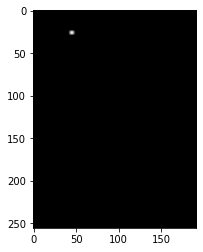

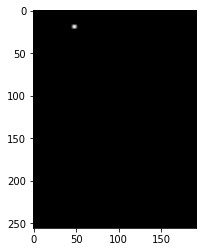

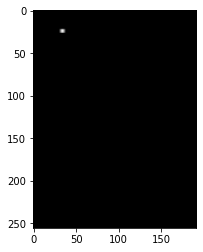

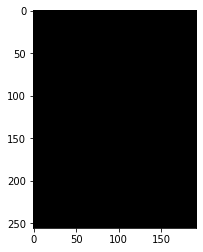

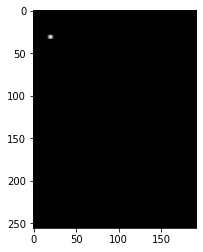

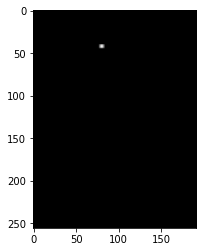

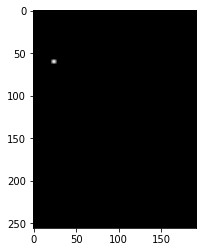

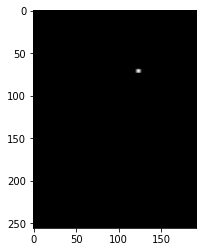

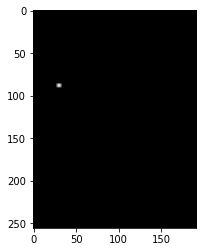

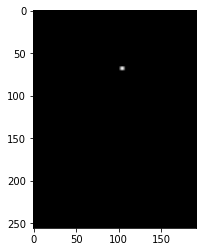

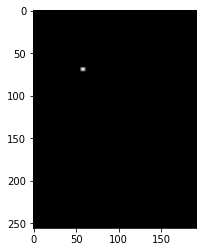

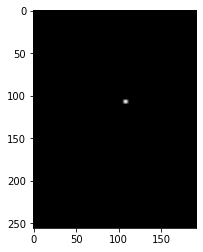

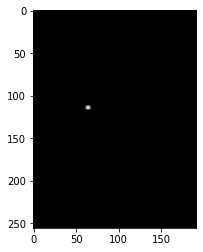

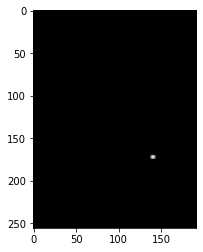

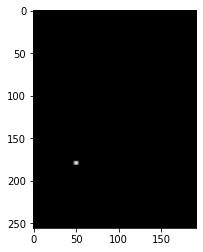

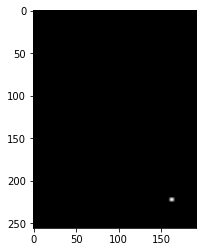

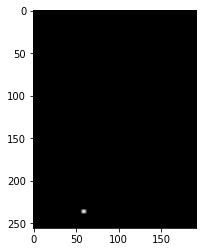

In [ ]:
# Applying Gaussian blur
transform = T.GaussianBlur((7,5), sigma = 2.0)
heatmap_tensor = transform(heatmap_tensor)
# print(heatmap_tensor.shape)
for idx, k in enumerate(range(len(keypoint_text))):
  fig1, ax1 = plt.subplots(figsize=(6, 4))
  # print(heatmap_tensor[idx].numpy().min(),heatmap_tensor[idx].numpy().max()) 
  plt.imshow(heatmap_tensor[idx].numpy(), cmap='gray')
  

In [ ]:
# Downsample the heatmap by factor 4
heatmap_tensor = torch.unsqueeze(heatmap_tensor,0)
heatmap_resized = F.interpolate(heatmap_tensor, scale_factor=0.25) 
heatmap_resized = torch.squeeze(heatmap_resized,0)
print(heatmap_resized.shape)

torch.Size([17, 64, 48])


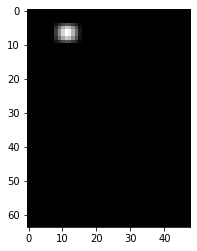

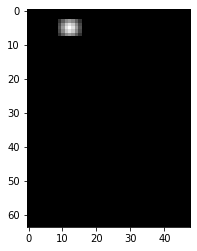

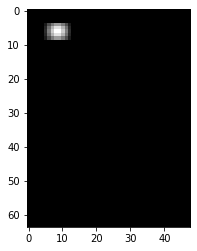

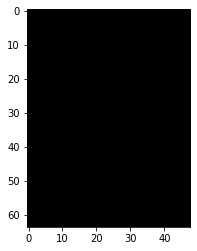

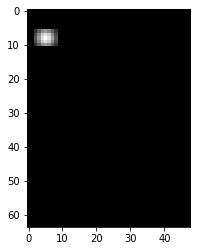

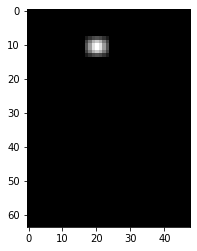

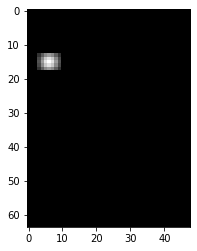

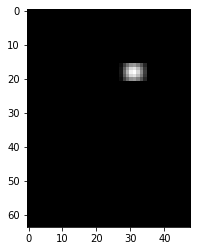

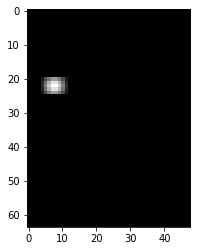

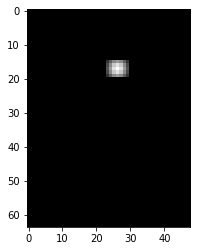

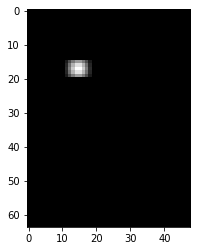

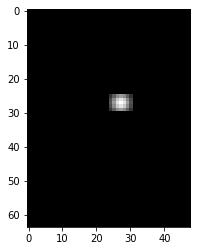

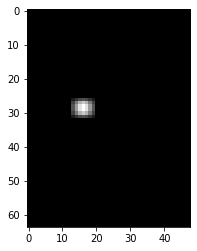

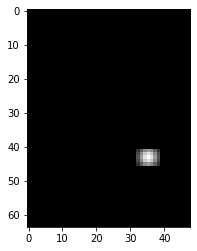

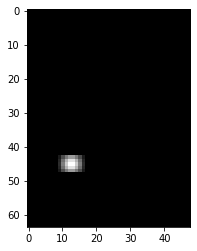

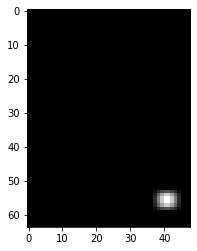

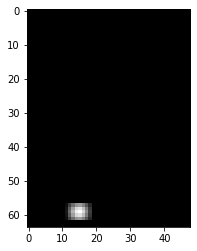

In [ ]:
for idx, k in enumerate(range(len(keypoint_text))):
 
  heatmap_2d = torch.unsqueeze(heatmap_resized[idx],0)
  heatmap_2d = transform(heatmap_2d)
  heatmap_resized[idx] = torch.squeeze(heatmap_2d,0)

  fig1, ax1 = plt.subplots(figsize=(6, 4))
  plt.imshow(heatmap_resized[idx].numpy(), cmap='gray')